In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [3]:
A = 5.81

band = 'z'
## Luminosity function parameters
alpha = -1
Ms = -22.1

## TF realtion parameters
slope = -8.46
zp = -20.89-0.08

In [4]:
####################################
def CurveFUN(x, A):

    logW0 = 2.5

    if band in ['w1', 'w2']:
        logW0=2.4
    else:
        logW0=2.5

    logW = x

    X0 = logW0 - 2.5
    X = logW-2.5

    B = -2.*A*X0

    M = slope*X+zp-0.11
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

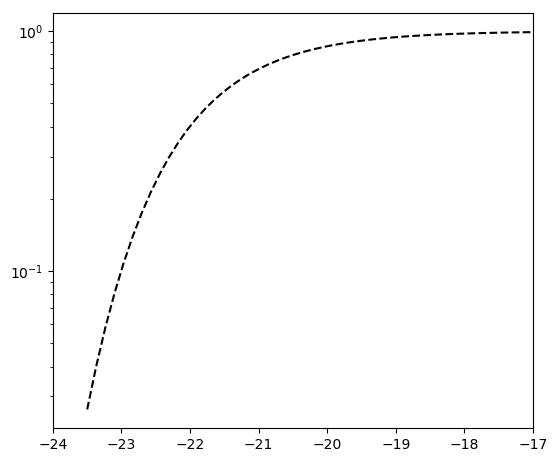

In [5]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])

M = np.linspace(-23.5,-17,50)
N = LFfunction(M, Ms, alpha)
ax.plot(M,N,'k--')

ax.set_yscale("log", nonposy='clip')

In [6]:
def myCurve(x, a, b, c):
    
    x0 = -b/2./a
    y = a*x**2+b*x+c
    
    indx, = np.where(x>=x0)
    y[indx] = a*x0**2+b*x0+c
    
    indx, = np.where(x<-21)
    x0 = -21.
    y[indx] = a*x0**2+b*x0+c
    
    return y

def CurveFUN(logW, A):

    if band in ['w1', 'w2']:
        logW0=2.4
    elif band in ['i', 'z']:
        logW0=2.5
    else:
        logW0=2.5


    X0 = logW0 - 2.5
    X = logW-2.5

    B = -2.*A*X0

    M = slope*X+(zp)

    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))
    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

0.005719150724930612


<ErrorbarContainer object of 3 artists>

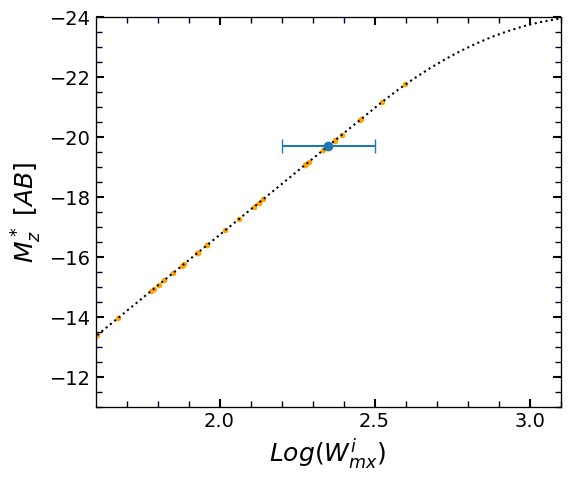

In [7]:
########################################################
def curveSimul(A, Ms, alpha, size=100000, seed=0):
    
    
    if band in ['w1', 'w2']:
        logW0=2.4
    else:
        logW0=2.5

    logW = x
    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+zp-0.04
    M0 = slope*X0+zp-0.04
    
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))
    
    A0 = A
    B0 = B+slope
    C0 = zp - (A*X0**2+B*X0)
    
    np.random.seed(seed)
    
    randMGAG = np.random.uniform(low=-28, high=0, size=size*10)
    randU = np.random.uniform(low=0, high=1, size=size*10)
    randLfunct = LFfunction(randMGAG, Ms, alpha)
    indx, = np.where(randU<randLfunct)
    simulMag  = randMGAG[indx]
    simulWimx1 = (simulMag-zp)/slope+2.5
    
    simulWimx2 = np.array([np.min(np.roots([A0, B0, C0-Msim])+2.5) for Msim in simulMag])    
    simulWimx = simulWimx1*0.
    for i, Msim in enumerate(simulMag):
        if Msim<M0:
            simulWimx[i] = simulWimx2[i]
        else:
            simulWimx[i] = simulWimx1[i]
            
    real_mag  = simulMag[:size]
    simulWimx = simulWimx[:size]
    
    simulMag = real_mag
    
    return simulMag, simulWimx
    
########################################################

fig, ax = makeFig(band=band, xLim = (1.6,3.1), yLim = (-11,-24), MAGabs=True)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

x = np.linspace(0,5,100)
y = CurveFUN(x, A)
yl = slope*(x-2.5)+zp 
    
real_mag, simulWimx = curveSimul(A, Ms, alpha, size=100, seed=0)


ax.plot(simulWimx, real_mag, '.', color='orange', alpha=1)
print np.std(real_mag-(slope*(simulWimx-2.5)+zp))


ax.plot(x,y, 'k:') 
# ax.plot(x,yl, 'r-') 

ax.errorbar([2.35], CurveFUN(2.35, A), xerr=0.15, capsize=5, fmt='o')

In [8]:
def Normal(x, mu, sigma):
    y = np.exp(-(x-mu)**2/(2.*sigma**2))
    return y/sigma/np.sqrt(2.*np.pi)

def simulFieldOBS(simulMag, simulWimx, logW, dlogW):
    
    delta_lst = simulMag*0.  
    Mag = CurveFUN(logW, A)
    
    weights = Normal(simulWimx, logW, dlogW)
    bias = simulMag - Mag
    
    
    average_bias = np.sum(bias*weights)/np.sum(weights) 

    return average_bias

#########################################################
n_simul = 20
logW = np.arange(1.0,3.1,0.1)
dlogW = {'0.01':0.01, '0.02':0.02, '0.05':0.05, '0.10':0.10, '0.20':0.20, '0.40':0.40, '0.80':0.80}
#########################################################
biasDict = {}

for key in dlogW:
    nW = len(logW)
    outputs = np.zeros(nW*n_simul)
    outputs = outputs.reshape(n_simul, nW)

    for j in range(nW):
        for i in range(n_simul):
            simulMag, simulWimx = curveSimul(A, Ms, alpha, size=7000, seed=i)
            outputs[i][j] = simulFieldOBS(simulMag, simulWimx, logW[j], dlogW[key])

    print key

    bias_w = np.median(outputs, 0)
    bias_err_w = np.std(outputs, 0)
    
    biasDict[key] = [bias_w, bias_err_w]

    

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


0.02
0.01
0.20
0.05
0.80
0.10
0.40


In [9]:
# for key in biasDict:
#     biasDict[key][0][biasDict[key][0] < 0]=0

Text(1.6,0.8,'i-band')

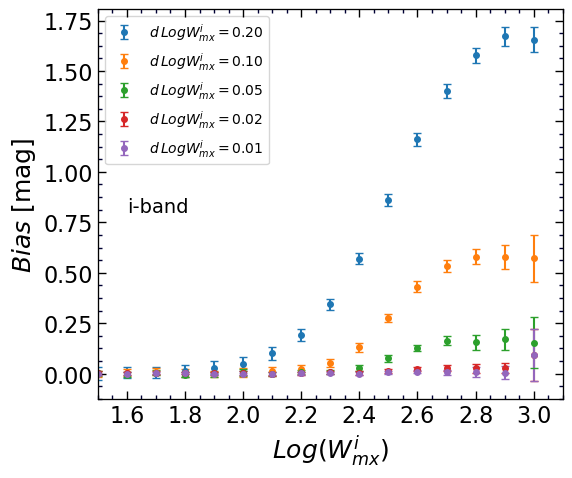

In [10]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def biasFuc(logW, a,b, c):
    x = (logW-c)
#     return a*(1+np.tanh(x*b))
    return a*sigmoid(x*b)
    
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(1.5,3.1)
# ax.plot([-12,-24],[0,0], 'k:')

for key in ['0.01', '0.02', '0.05', '0.10', '0.20'][::-1]:
    ax.errorbar(logW , biasDict[key][0], yerr=biasDict[key][1], fmt='o', capsize=3, markersize=4, label=r'$d\/LogW^i_{mx} = $'+key)
    
#     fit, cov = curve_fit(biasFuc, logW , biasDict[key][0]) #, sigma=biasDict[key][1])
#     ax.plot(logW, biasFuc(logW, fit[0], fit[1], fit[2]), 'k:')
#     print key, fit
    

ax.legend()

# ax.set_ylim(0,0.2)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$Bias$'+ ' [mag]', fontsize=18)


set_axes(ax)

ax.text(1.6,0.8,'i-band', fontsize=14)

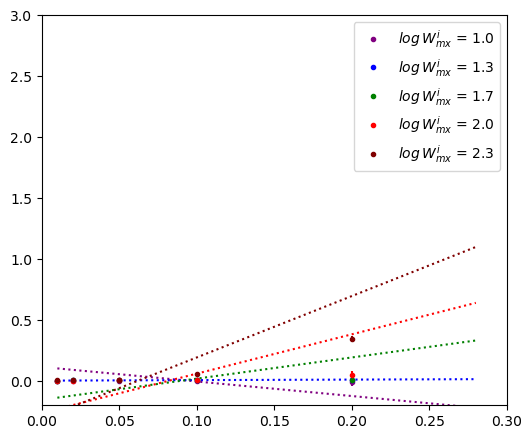

In [11]:
def plotME(ax, i, color='k'):
    
    X = []
    Y = []
    Ye = []
    for key in dlogW:
        ax.errorbar(dlogW[key], biasDict[key][0][i], yerr=biasDict[key][1][i], fmt='.', 
                    color=color)
        X.append(dlogW[key])
        Y.append(biasDict[key][0][i])
        Ye.append(biasDict[key][1][i])
        
    X  = np.asarray(X)
    Y  = np.asarray(Y)
    Ye = np.asarray(Ye)
    ax.plot([-1],[-1], '.', color=color, label=r'$log\/W^i_{mx}$'+' = %.1f'%logW[i])
    
    v = np.linspace(0.01,0.28,200)
    c = np.polyfit(X,Y, 1) # , cov=True, w=1./Ye)
    plt.plot(v,c[0]*v+c[1], ':', color=color)

        
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)
ax.set_xlim(0,0.3)
ax.set_ylim(-0.2,3)

plotME(ax, 0, color='purple')
plotME(ax, 3, color='b')
plotME(ax, 7, color='g')
plotME(ax, 10, color='r')
plotME(ax, 13, color='maroon')




ax.legend()

In [12]:
myTable = Table()

myTable.add_column(Column(data=logW, name='logWimx', format='%0.1f'))

for key in ['0.01', '0.02', '0.05', '0.10', '0.20', '0.40', '0.80']:
    myTable.add_column(Column(data=biasDict[key][0], name=key, format='%0.4f'))
    myTable.add_column(Column(data=biasDict[key][1], name=key+'_err', format='%0.4f'))

myTable.write('DMcalc_z_chort.csv', format='ascii.fixed_width',delimiter=',', bookend=False, overwrite=True) 
